### Prediction Diabetes with Multilayer Perceptron

#### Import Libraries

In [495]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from keras.regularizers import l2
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)


#### Importing the data

In [496]:
df = pd.read_csv("C:/Users/asus/OneDrive - Universidade de Lisboa/Desktop/Pyhton/Projects/Prediction Diabetes with multilayer perception/diabetes.csv")

In [497]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


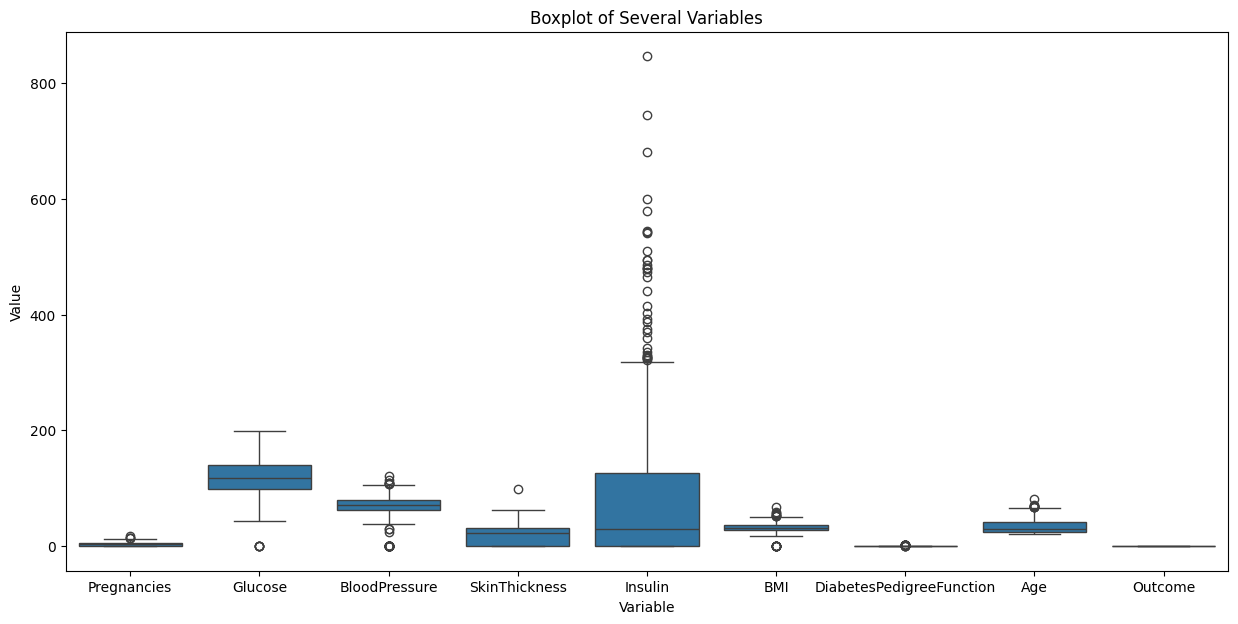

In [498]:
df_melted = df.melt(var_name="Variable", value_name="Value")
plt.figure(figsize=(15, 7))
sns.boxplot(x='Variable', y='Value', data=df_melted)
plt.title("Boxplot of Several Variables")
plt.show()

Insulin values seem to have a broader distribution, with more outliers.

C:\Users\asus\AppData\Local\Temp\ipykernel_25768\3227882625.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\asus\AppData\Local\Temp\ipykernel_25768\3227882625.py:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


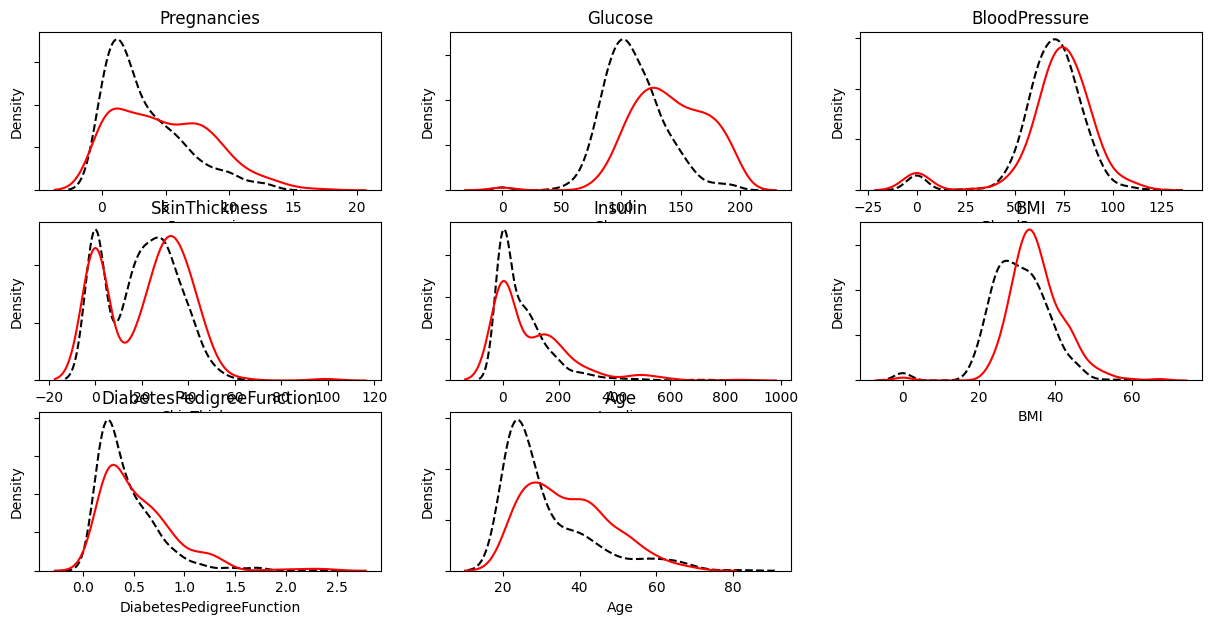

In [499]:
plt.subplots(3,3,figsize=(15,7))

# Plot a density plot for each variable
for idx, col in enumerate(df.columns):
    ax = plt.subplot(3,3,idx+1)
    ax.yaxis.set_ticklabels([])
    sns.kdeplot(
    data=df[df.Outcome == 0],
    x=col,
    ax=ax,
    linestyle='--',
    color='black',
    label="No Diabetes"
    )
    sns.kdeplot(
    data=df[df.Outcome == 1],
    x=col,
    ax=ax,
    linestyle='-',
    color='red',
    label="Diabetes"
    )
    ax.set_title(col)
    
#Hide the 9th subplot (bottom right since there are only 8 plots)
plt.subplot(3,3,9).set_visible(False)

plt.show()

Density Analysis:
- Pregnancies: Similar distribution for diabetic and non-diabetic patients.
- Glucose: Higher glucose levels observed in diabetic patients.
- Blood Pressure: Similar distribution across both groups.
- Skin Thickness: Similar distribution across both groups.
- Insulin: Similar distribution across both groups.
- BMI: Slightly higher BMI values among diabetic patients.
- Diabetes Pedigree Function: Similar distribution in both groups.
- Age: Diabetic patients tend to be older.

#### Missing data

In [500]:
df.isnull().any()
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [501]:
zero_check_cols = df.columns.difference(['Pregnancies', 'Outcome']) ## excluded pregnancies because is valid that a patient wasn't pregnant before
(df[zero_check_cols] == 0).sum()

Age                           0
BMI                          11
BloodPressure                35
DiabetesPedigreeFunction      0
Glucose                       5
Insulin                     374
SkinThickness               227
dtype: int64

To address missing data, common approaches include removing rows with missing values, imputing them using the mean or mode of the existing data, or predicting the missing values using a separate machine learning model. In this project, I experimented with mean imputation and KNN imputation. I did not apply linear regression imputation, as there was no clear linear relationship between the relevant features.

In [502]:
invalid_zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

df[invalid_zero_cols] = df[invalid_zero_cols].replace(0, np.nan)

## Mean Imputation

df_mean_imputed = df.copy()
df_mean_imputed[invalid_zero_cols] = df_mean_imputed[invalid_zero_cols].fillna(df_mean_imputed[invalid_zero_cols].mean())


## KNN Imputation

df_knn = df.copy()
imputer = KNNImputer(n_neighbors=5)
df_knn = pd.DataFrame(imputer.fit_transform(df_knn), columns=df.columns)

## for now, we will use mean imputation

df = df_mean_imputed.copy()

#### Data Standardization

In [503]:
df_scaled = preprocessing.scale(df)
df_scaled = pd.DataFrame(df_scaled,columns=df.columns)
df_scaled['Outcome'] = df['Outcome']
df = df_scaled

df.describe().loc[['mean','std','max'],].round(2).abs()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
mean,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.35
std,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,0.48
max,3.91,2.54,4.1,7.95,8.13,5.04,5.88,4.06,1.00


#### Class Imbalance

In [504]:
df.groupby('Outcome').count()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,500,500,500,500,500,500,500,500
1,268,268,268,268,268,268,268,268


There's a class imbalance in the dataset, so it's important to handle it after splitting the data. That way, only the training set is balanced, and the validation and test sets still reflect the real-world distribution. This helps avoid misleading results and keeps the model evaluation realistic.

#### Data Splitting

We're splitting the dataset into three parts:

Training set (64%) – used to train the neural network

Validation set (16%) – used to tune hyperparameters

Test set (20%) – used at the end to evaluate how well the model performs on unseen data

In [505]:
X = df.loc[:, df.columns != 'Outcome']
y = df.loc[:, 'Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # first, we divide the test and training set

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size = 0.2) # we divide the trainign set into training and validation set

#### Class Imbalance - applied to the training set

In [506]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train)
class_weight_dict = dict(enumerate(class_weights))


#### Data Modelling

In [507]:
## if tunned model

def build_model(hp):
    model = Sequential()

    l2_strength = hp.Float("l2_strength", min_value=1e-5, max_value=1e-2, sampling="log")

    # Tune number of units in first Dense layer between 16 and 64 (step 16)
    model.add(Dense(units=hp.Int('units_1', min_value=16, max_value=64, step=16), 
                    activation='relu', input_dim=8, kernel_regularizer=l2(l2_strength)))
    model.add(Dropout(0.3))
    
    # Tune number of units in second Dense layer between 8 and 32 (step 8)
    model.add(Dense(units=hp.Int('units_2', min_value=8, max_value=32, step=8), activation='relu', kernel_regularizer=l2(l2_strength)))
    model.add(Dropout(0.3))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # Tune learning rate for Adam optimizer
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,             # max number of hyperparameter combinations to try
    executions_per_trial=1,    # number of model trainings per trial (for stability)
    directory='my_dir',        # where to save logs
    project_name='diabetes_classification'
)

tuner.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
Best units in first layer: {best_hps.get('units_1')}
Best units in second layer: {best_hps.get('units_2')}
Best learning rate: {best_hps.get('learning_rate')}
""")

Reloading Tuner from my_dir\diabetes_classification\tuner0.json

The hyperparameter search is complete.
Best units in first layer: 64
Best units in second layer: 24
Best learning rate: 0.001



In [508]:
## model construction

## manual
# model = Sequential()
# model.add(Dense(32, activation='relu', input_dim=8, kernel_regularizer=l2(0.001))) # 32 nodes with dimension 8 because there are 8 features in x_train
# model.add(Dropout(0.3))  # Drop 30% of neuron
# model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))# second hidden layer
# model.add(Dropout(0.3))  # Drop 30% of neuron
# model.add(Dense(1, activation='sigmoid'))

## tunned
model = tuner.hypermodel.build(best_hps)


c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [509]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [510]:
model.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict # handle class imbalance
)

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5318 - loss: 0.7121 - val_accuracy: 0.7073 - val_loss: 0.6443
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7203 - loss: 0.5925 - val_accuracy: 0.6911 - val_loss: 0.5959
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7055 - loss: 0.5937 - val_accuracy: 0.7154 - val_loss: 0.5732
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7295 - loss: 0.5556 - val_accuracy: 0.6992 - val_loss: 0.5648
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7497 - loss: 0.5326 - val_accuracy: 0.7073 - val_loss: 0.5602
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7282 - loss: 0.5552 - val_accuracy: 0.7073 - val_loss: 0.5458
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7300 - loss: 0.5294 - val_accuracy: 0.7073 - val_loss: 0.5448
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7146 - loss: 0.5575 - val_accuracy: 0.7154 - 

In [511]:
scores = model.evaluate(X_train,y_train)
print("Training Accuracy: %.2f%%\n" % (scores[1]*100))
scores = model.evaluate(X_test,y_test)
print("Testing Accuracy: %.2f%%\n" % (scores[1]*100))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8695 - loss: 0.3093 
Training Accuracy: 85.95%

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7888 - loss: 0.5048 
Testing Accuracy: 76.62%



KNN imputation seems to lead to more overfitting compared to mean imputation. That makes sense, because KNN fills in missing values based on the closest data points, which can capture patterns that are specific to the training data. This might introduce noise or overly complex relationships that don’t generalize well to new data, while mean imputation keeps things simpler and more stable.

#### Evalution of results

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


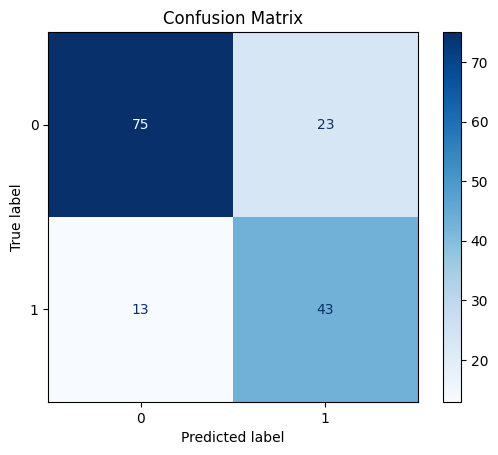

              precision    recall  f1-score   support

           0       0.85      0.77      0.81        98
           1       0.65      0.77      0.70        56

    accuracy                           0.77       154
   macro avg       0.75      0.77      0.76       154
weighted avg       0.78      0.77      0.77       154



In [512]:
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred))


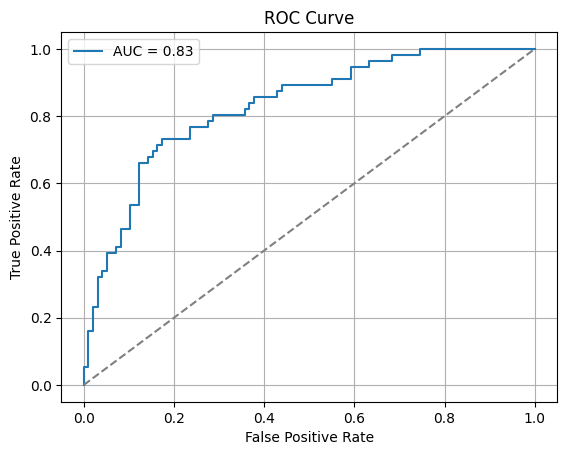

In [513]:
auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

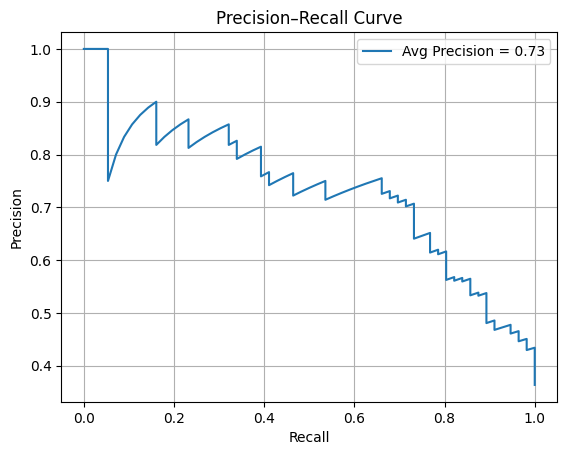

In [514]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

plt.plot(recall, precision, label=f"Avg Precision = {avg_precision:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.show()